In [18]:
import tensorflow as tf
import keras
import cv2
import scipy
import torch 
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms,datasets
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

<p dir="rtl">
در مدل مورد استفاده، یک تصویر با حداقل اندازه 32x32 با 3 کانال مورد نیاز است و این تابع، تصویر را برای استفاده در مدل آماده میکند. ورودی این تابع image size میتواند اندازه تصویر را به مقدار دلخواه تغییر بدهد.

</p>

In [19]:
def resizeImageArray(source,image_size):
    resize = np.resize(source,[source.shape[0],image_size,image_size,1])
    for i in range(source.shape[0]):
        a = cv2.resize(source[i], dsize=(image_size, image_size), interpolation=cv2.INTER_LANCZOS4)
        b = np.resize(a,[image_size,image_size,1])
        resize[i] = b
    resize = np.repeat(resize,3,axis=3)
    return resize

<p dir="rtl">
این تابع برای آماده سازی مجموعه داده گرفته شده میباشد و مقداری از داده های train برای validation استفاده میشود.
تعداد داده های train برابر 55000 و تعداد داده های validation برابر 5000 میباشد  
</p>

In [20]:
def load_and_preprocess_data(debug=False):

    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    indexes = np.arange(X_train.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_train = X_train[indexes]
    y_train = y_train[indexes]
      
    val_count = 5000
    X_val = X_train[:val_count]
    y_val = y_train[:val_count]
    X_train = X_train[val_count:]
    y_train = y_train[val_count:]

    

    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

<p dir="rtl">
بارگذاری داده های ورودی و مجموعه داده های خروجی برای قرار گرفتن در مدل و تغییر اندازه ورودی.
استفاده از one hot برای y_test,y_train,y_validation.


</p>

In [21]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_preprocess_data()

image_size = 32
X_train = resizeImageArray(X_train,image_size)
y_train =to_categorical(y_train)

X_validation = np.reshape(X_val, [-1, 28, 28, 1])
X_validation = resizeImageArray(X_validation,image_size)
y_validation =to_categorical(y_val) 



X_test = np.reshape(X_test,[-1,28,28,1])
X_test = resizeImageArray(X_test, image_size)
y_test =to_categorical(y_test)

In [22]:


print('X train = ', X_train.shape)
print('y train = ',y_train.shape)
print('X validation = ',X_validation.shape)
print('X validation = ',y_validation.shape)
print('X test = ',X_test.shape)
print('y test = ',y_test.shape)



X train =  (55000, 32, 32, 3)
y train =  (55000, 10)
X validation =  (5000, 32, 32, 3)
X validation =  (5000, 10)
X test =  (10000, 32, 32, 3)
y test =  (10000, 10)


<p dir="rtl">
ایجاد یک Image Data Generator  برای استفاده در resnet50
</p>

In [23]:
batch_size = 128

# Preprocess using ResNet50 preprocess
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(
     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow(
    x =  X_train ,  
    y =  y_train ,
    batch_size=batch_size)

validation_generator = validation_datagen.flow(
    x = X_validation , 
    y = y_validation , 
    batch_size=batch_size)

test_generator = test_datagen.flow(
    x = X_test , 
    y = y_test , 
    batch_size=batch_size)

<p dir="rtl">
مدلی را که برای transfer learning میخواهیم استفاده کنیم را  بارگذاری میکنیم. برای کوتاه کردن لایه بالایی مدل از include_top = False استفاده میکنیم .ما میخواهیم از وزن های مدل از قبل آموزش دیده استفاده کنیم برای همین از   imagenet استفاده میکنیم.
</p>

In [24]:
image_size = 32
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

<h1>‫‪feature‬‬ ‫‪extraction‬‬</h1> ‫‪ ‫‬ 

برای فریز کردن مدل تا وزنها به روز نشوند

In [25]:
base_model.trainable = False

کد زیر برای این نوشته شده است که خروجی با خروجی مورد نظر ما مظابقت داشته باشد

In [26]:
model = tf.keras.Sequential([
  base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

<p dir="rtl">
تابع ضرر، بهینه ساز و متریک مورد استفاده را  با استفاده از بهینه ساز RMSprop تعیین میکنیم.
</p>

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0006),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [28]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n //batch_size
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              validation_steps = validation_steps,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


429/429 [==============================] - 16s 30ms/step - loss: 1.3491 - accuracy: 0.4996 - val_loss: 1.0140 - val_accuracy: 0.6266
Epoch 2/10
429/429 [==============================] - 12s 28ms/step - loss: 0.9460 - accuracy: 0.6415 - val_loss: 0.8090 - val_accuracy: 0.6907
Epoch 3/10
429/429 [==============================] - 12s 29ms/step - loss: 0.8484 - accuracy: 0.6805 - val_loss: 0.8351 - val_accuracy: 0.6819
Epoch 4/10
429/429 [==============================] - 12s 28ms/step - loss: 0.7933 - accuracy: 0.6982 - val_loss: 0.6842 - val_accuracy: 0.7522
Epoch 5/10
429/429 [==============================] - 12s 28ms/step - loss: 0.7574 - accuracy: 0.7139 - val_loss: 0.8124 - val_accuracy: 0.7105
Epoch 6/10
429/429 [==============================] - 12s 28ms/step - loss: 0.7318 - accuracy: 0.7244 - val_loss: 0.7093 - val_accuracy: 0.7330
Epoch 7/10
429/429 [==============================] - 12s 28ms/step - loss: 0.7154 - accuracy: 0.7291 - val_loss: 0.6366 - val_accuracy: 0.7604
Epo

از نمودار های زیر برای درک بهتر عملکرد مدل استفاده میکنیم

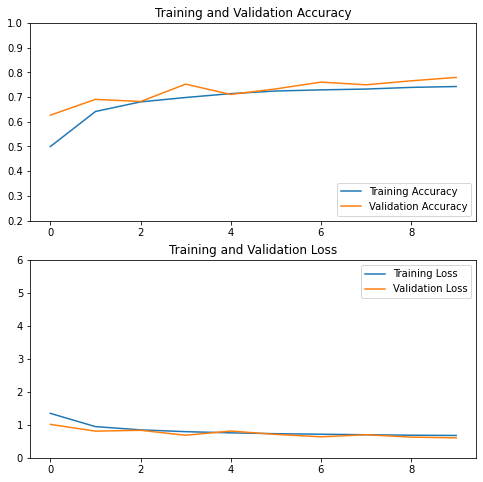

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [30]:
score, acc = model.evaluate_generator(generator=test_generator,steps=test_generator.n //batch_size)
print('Score :%f, Accuracy : %f'%(score,acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Score :0.615788, Accuracy : 0.764123


<h1>‫‪finetune‬‬</h1>
در این سناریو وزن ها را از حالت فریز خارج میکنیم و در ابتدا مدل از وزنهای آموزش دیده مدل انتخابی استفاده میکند ولی در مرحله آموزش بعدی امکان تغییر پارامتر های مدل وجود دارد


In [31]:
#Unfreeze weight model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 150
#Freeze weight layer yang tidak ingin ditrain yaitu semua layer sebelum layer 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [32]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [33]:
history_fine = model.fit(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)


Epoch 1/10
429/429 [==============================] - 21s 41ms/step - loss: 1.0432 - accuracy: 0.7451 - val_loss: 1.3736 - val_accuracy: 0.5473
Epoch 2/10
429/429 [==============================] - 17s 39ms/step - loss: 0.4957 - accuracy: 0.8279 - val_loss: 0.5734 - val_accuracy: 0.8271
Epoch 3/10
429/429 [==============================] - 16s 38ms/step - loss: 0.4116 - accuracy: 0.8537 - val_loss: 0.6186 - val_accuracy: 0.8181
Epoch 4/10
429/429 [==============================] - 16s 38ms/step - loss: 0.3643 - accuracy: 0.8688 - val_loss: 1.5183 - val_accuracy: 0.7893
Epoch 5/10
429/429 [==============================] - 16s 38ms/step - loss: 0.3260 - accuracy: 0.8821 - val_loss: 0.7760 - val_accuracy: 0.8387
Epoch 6/10
429/429 [==============================] - 17s 39ms/step - loss: 0.3063 - accuracy: 0.8903 - val_loss: 0.5401 - val_accuracy: 0.8488
Epoch 7/10
429/429 [==============================] - 17s 39ms/step - loss: 0.2802 - accuracy: 0.8977 - val_loss: 1.2676 - val_accuracy:

کد های زیر برای رسم نمودار جهت فهم بهتر مدل استفاده میشود

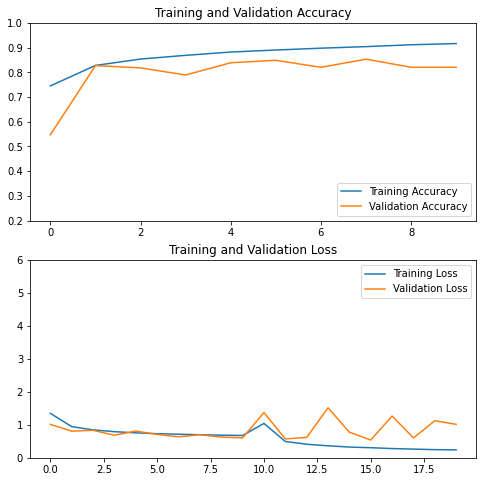

In [36]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
score, acc = model.evaluate_generator(generator=test_generator,steps=test_generator.n //batch_size)
print('Score :%f, Accuracy : %f'%(score,acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Score :1.061297, Accuracy : 0.805789
